<a href="https://colab.research.google.com/github/dongzooo/Quant-with-py/blob/main/%EC%BA%94%EB%93%A4%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D/3%EB%B6%84%EB%B4%895%EC%9D%B4%ED%8F%89_%EB%B3%80%EA%B3%A1_%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3분봉5이평변곡 시 1분봉 패턴분석

### 1. 데이터 불러오기 및 전처리

In [290]:
# 폰트 설치 : 글자 깨지면 런타임 재실행
!pip install yfinance --quiet

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (17.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122545 files and dir

In [1]:
import yfinance as yf
import pandas as pd
import datetime
from google.colab import files

import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
matplotlib.rc('axes', unicode_minus=False)

In [200]:
files.upload()

{}

In [2]:
#14시50분 이후 데이터는 날리는 작업은 이평성 생성후 한다
target_time = pd.to_datetime("14:50:00", format="%H:%M:%S").strftime('%H:%M:%S')

df1Min = pd.read_csv("/content/ytd1MinData1.csv")
df1Min = df1Min.drop(df1Min.columns[0], axis=1)
df1Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
# df1Min = df1Min[df1Min['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
# df1Min = df1Min.reset_index(drop=True)
df1Min.head()

df3Min = pd.read_csv("/content/ytd3MinData1.csv")
df3Min = df3Min.drop(df3Min.columns[0], axis=1)
df3Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
df3Min['Timestamp'] = pd.to_datetime(df3Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
# df3Min = df3Min[df3Min['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
# df3Min = df3Min.reset_index(drop=True)

df10Min = pd.read_csv("/content/ytd10MinData1.csv")
df10Min = df10Min.drop(df10Min.columns[0], axis=1)
df10Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
df10Min['Timestamp'] = pd.to_datetime(df10Min['Timestamp'], format="%y-%m-%d %H:%M:%S")

df30Min = pd.read_csv("/content/ytd30MinData1.csv")
df30Min = df30Min.drop(df30Min.columns[0], axis=1)
df30Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
df30Min['Timestamp'] = pd.to_datetime(df30Min['Timestamp'], format="%y-%m-%d %H:%M:%S")

In [3]:
df30Min.tail()

,Timestamp,Open,High,Low,Close,Volume
895,2023-05-25 13:30:00,16570,16595,16550,16565,535311
896,2023-05-25 14:00:00,16565,16630,16560,16620,1044037
897,2023-05-25 14:30:00,16615,16690,16610,16675,1247237
898,2023-05-25 15:00:00,16670,16675,16620,16645,610742
899,2023-05-25 15:30:00,16620,16620,16620,16620,177823


### 2. 분봉데이터 지표계산

#### 1) 3, 10, 30분봉 지표계산

In [4]:
# 3분봉 이평선 생성
df3Min['5MA'] = df3Min['Close'].rolling(window=5).mean()
# df3Min['Return'] = df3Min['Close'].pct_change() * 100
df3Min.head()
# df3Min['MA_Crossover'] = df3Min['Moving Average'].diff().shift(-1).fillna(0).apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

df10Min['10MA'] = df10Min['Close'].rolling(window=10).mean()
df30Min['5MA'] = df30Min['Close'].rolling(window=5).mean()
df30Min.tail()

,Timestamp,Open,High,Low,Close,Volume,5MA
895,2023-05-25 13:30:00,16570,16595,16550,16565,535311,16595.0
896,2023-05-25 14:00:00,16565,16630,16560,16620,1044037,16597.0
897,2023-05-25 14:30:00,16615,16690,16610,16675,1247237,16604.0
898,2023-05-25 15:00:00,16670,16675,16620,16645,610742,16616.0
899,2023-05-25 15:30:00,16620,16620,16620,16620,177823,16625.0


In [5]:
df1Min['Timestamp'].iloc[0]

Timestamp('2023-05-23 13:06:00')

In [6]:
#3,10,30분봉과 1분봉 시계열 시작 맞추기
df1Min['Timestamp'].iloc[0]
df3Min = df3Min[df3Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
df3Min = df3Min.reset_index(drop=True)

df10Min = df10Min[df10Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
df10Min['10MA우상향'] = df10Min['10MA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
df10Min = df10Min.reset_index(drop=True)

df30Min = df30Min[df30Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
df30Min['5MA우상향'] = df30Min['5MA'].pct_change().apply(lambda x: 1 if x > 0 else 0)
df30Min = df30Min.reset_index(drop=True)

df10Min

<ipython-input-6-488afa1cf246>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10Min['10MA우상향'] = df10Min['10MA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
<ipython-input-6-488afa1cf246>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df30Min['5MA우상향'] = df30Min['5MA'].pct_change().apply(lambda x: 1 if x > 0 else 0)


,Timestamp,Open,High,Low,Close,Volume,10MA,10MA우상향
0,2023-05-23 13:10:00,16800,16835,16795,16835,169194,16854.0,0
1,2023-05-23 13:20:00,16835,16865,16830,16840,243968,16850.0,0
2,2023-05-23 13:30:00,16835,16845,16820,16845,96650,16844.5,0
3,2023-05-23 13:40:00,16845,16845,16800,16810,224803,16835.5,0
4,2023-05-23 13:50:00,16815,16830,16805,16815,101252,16828.0,0
...,...,...,...,...,...,...,...,...
87,2023-05-25 14:40:00,16645,16670,16640,16655,201108,16600.0,1
88,2023-05-25 14:50:00,16660,16690,16650,16675,409245,16608.0,1
89,2023-05-25 15:00:00,16670,16675,16640,16650,220475,16615.5,1
90,2023-05-25 15:10:00,16645,16665,16620,16645,390267,16624.0,1


In [7]:
df30Min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  33 non-null     datetime64[ns]
 1   Open       33 non-null     int64         
 2   High       33 non-null     int64         
 3   Low        33 non-null     int64         
 4   Close      33 non-null     int64         
 5   Volume     33 non-null     int64         
 6   5MA        33 non-null     float64       
 7   5MA우상향     33 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 2.2 KB


#### 2) 1분봉 지표계산

In [8]:
# 1분봉 이동평균선 계산
df1Min['3MA'] = df1Min['Close'].rolling(window=3).mean()
df1Min['5MA'] = df1Min['Close'].rolling(window=5).mean()
df1Min['10MA'] = df1Min['Close'].rolling(window=10).mean()
df1Min['20MA'] = df1Min['Close'].rolling(window=20).mean()
df1Min['60MA'] = df1Min['Close'].rolling(window=60).mean()

#우상향여부
df1Min['3MA우상향'] = df1Min['3MA'].pct_change()
df1Min['5MA우상향'] = df1Min['5MA'].pct_change()
df1Min['10MA우상향'] = df1Min['10MA'].pct_change()
df1Min['20MA우상향'] = df1Min['20MA'].pct_change()
df1Min['60MA우상향'] = df1Min['60MA'].pct_change()

df1Min['3MA우상향'] = df1Min['3MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['5MA우상향'] = df1Min['5MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['10MA우상향'] = df1Min['10MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['20MA우상향'] = df1Min['20MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['60MA우상향'] = df1Min['60MA우상향'].apply(lambda x: 1 if x > 0 else 0)

#거래이평선 계산
df1Min['2VMA'] = df1Min['Volume'].rolling(window=2).mean()
df1Min['5VMA'] = df1Min['Volume'].rolling(window=5).mean()
df1Min['10VMA'] = df1Min['Volume'].rolling(window=10).mean()
df1Min['20VMA'] = df1Min['Volume'].rolling(window=20).mean()
df1Min['60VMA'] = df1Min['Volume'].rolling(window=60).mean()

#현봉 전봉 거래량 비교
df1Min['VolumeChange'] = df1Min['Volume'].pct_change()

#데이터프레임 datetime으로 변경
df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
df1Min.head()

,Timestamp,Open,High,Low,Close,Volume,3MA,5MA,10MA,20MA,...,5MA우상향,10MA우상향,20MA우상향,60MA우상향,2VMA,5VMA,10VMA,20VMA,60VMA,VolumeChange
0,2023-05-23 13:06:00,16795,16805,16790,16800,3571,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-23 13:07:00,16800,16800,16790,16790,2906,NaN,NaN,NaN,NaN,...,0,0,0,0,3238.5,NaN,NaN,NaN,NaN,-0.186222
2,2023-05-23 13:08:00,16795,16800,16790,16800,24269,16796.666667,NaN,NaN,NaN,...,0,0,0,0,13587.5,NaN,NaN,NaN,NaN,7.351342
3,2023-05-23 13:09:00,16800,16800,16790,16800,13441,16796.666667,NaN,NaN,NaN,...,0,0,0,0,18855.0,NaN,NaN,NaN,NaN,-0.446166
4,2023-05-23 13:10:00,16800,16805,16795,16805,4388,16801.666667,16799.0,NaN,NaN,...,0,0,0,0,8914.5,9715.0,NaN,NaN,NaN,-0.673536


In [9]:
df30Min.sum()

<ipython-input-9-c2ef8381f998>:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df30Min.sum()


Open        550475.0
High        551600.0
Low         549305.0
Close       550320.0
Volume    25215818.0
5MA         550738.0
5MA우상향          11.0
dtype: float64

In [10]:
#df3Min에 10분봉 10이평선 30분봉 5이평선 데이터 추가
df3Min['10분단위'] = df3Min['Timestamp'].dt.floor('10min')
df3Min['30분단위'] = df3Min['Timestamp'].dt.floor('30min')

#우상향 여부담을 변수
df3Min['10Min10MA'] = 0
df3Min['30Min5MA'] = 0

for i in range(len(df10Min)):
    timestamp = df10Min.loc[i, 'Timestamp']
    mask = df3Min['10분단위'] == timestamp
    df3Min.loc[mask, '10Min10MA'] = df10Min.loc[i, '10MA우상향']

for i in range(len(df30Min)):
    timestamp = df30Min.loc[i, 'Timestamp']
    mask = df3Min['30분단위'] == timestamp
    df3Min.loc[mask, '30Min5MA'] = df30Min.loc[i, '5MA우상향']

# df1Min.loc[df1Min['10분단위'].isin(df10Min['Timestamp']), '10Min10MA'] = df10Min['10MA우상향']
# df1Min.loc[df1Min['30분단위'].isin(df10Min['Timestamp']), '30Min5MA'] = df30Min['5MA우상향']
# df1Min.iloc[:10]

In [11]:
# len(df1Min['5MA우상향'][df1Min['5MA우상향']==1])
# a=df1Min['5MA우상향'][df1Min['5MA우상향']==1]
# df1Min[['Timestamp','5MA우상향']][100:200]
df3Min

,Timestamp,Open,High,Low,Close,Volume,5MA,10분단위,30분단위,10Min10MA,30Min5MA
0,2023-05-23 13:06:00,16795,16805,16790,16800,30746,16810.0,2023-05-23 13:00:00,2023-05-23 13:00:00,0,0
1,2023-05-23 13:09:00,16800,16810,16790,16800,23223,16806.0,2023-05-23 13:00:00,2023-05-23 13:00:00,0,0
2,2023-05-23 13:12:00,16800,16820,16800,16820,76682,16805.0,2023-05-23 13:10:00,2023-05-23 13:00:00,0,0
3,2023-05-23 13:15:00,16820,16835,16815,16830,48458,16809.0,2023-05-23 13:10:00,2023-05-23 13:00:00,0,0
4,2023-05-23 13:18:00,16830,16835,16825,16835,61346,16817.0,2023-05-23 13:10:00,2023-05-23 13:00:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
300,2023-05-25 15:12:00,16630,16645,16620,16645,87242,16647.0,2023-05-25 15:10:00,2023-05-25 15:00:00,1,1
301,2023-05-25 15:15:00,16650,16665,16645,16655,150664,16647.0,2023-05-25 15:10:00,2023-05-25 15:00:00,1,1
302,2023-05-25 15:18:00,16650,16660,16645,16645,57308,16644.0,2023-05-25 15:10:00,2023-05-25 15:00:00,1,1
303,2023-05-25 15:30:00,16620,16620,16620,16620,137624,16639.0,2023-05-25 15:30:00,2023-05-25 15:30:00,1,1


### 3. 변곡 시 1분봉 뷰 분석

#### 1) 수익나는 변곡시점 탐색함수



In [12]:
# 수익나는 변곡시점 찾는 알고리즘 : 3분봉 5이평 변곡시 30분봉 5이평, 10분봉 10이평이 우상향일 때 매수, 0.5%이익이면 익절, 전봉저가 이탈&0.5%손실
def buyFindInflection(n, df, col_name):
    turning_points = []
    start_num = n + 1

    for i in range(start_num, len(df)):
      buyPrice = 0
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
        if df['30Min5MA'].iloc[i] == 1 and df['10Min10MA'].iloc[i] == 1 :
          buyPrice = df['Close'].iloc[i]
          targetPrice = buyPrice + (buyPrice*0.005)
          stopLossPrice = buyPrice - (buyPrice*0.005)
          #매수 시물레이션
          for j in range(i,len(df)) :
            # 손절 조건: 현봉저가가 전봉저가보다 낮아지면
            if df['Low'].iloc[j] < df['Low'].iloc[j-1] and df['Close'].iloc[j] <= stopLossPrice:
                break
            #익절조건
            elif df['Close'].iloc[j] >= targetPrice :
                turning_points.append(i)
                break
    return turning_points

In [13]:
# 변곡발생만 검색
def findInflection(n, df, col_name):
    turning_points = []
    start_num = n + 1
    for i in range(start_num, len(df)):
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
              turning_points.append(i)
    return turning_points

#### 2) 3분봉데이터 정규화

In [14]:
#수익이나는 인덱스 조사
turning_points = buyFindInflection(5,df3Min,"5MA")

#데이터프레임에 수익여부 넣기
df3Min_Infection = pd.DataFrame(columns=df3Min.columns)
df3Min_Infection = df3Min
df3Min_Infection['Profitable'] = 0

# 수익이 나는 경우에 해당하는 행의 'Profitable' 열 값을 1로 설정
df3Min_Infection.loc[turning_points, 'Profitable'] = 1
df3Min_Infection[df3Min_Infection['Profitable'] == 1]


#2시50분 이후 매매 기록 삭제
df3Min_Infection['Timestamp'] = pd.to_datetime(df3Min_Infection['Timestamp'], format="%y-%m-%d %H:%M:%S")
df3Min_Infection = df3Min_Infection[df3Min_Infection['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
df3Min_Infection = df3Min_Infection.reset_index(drop=True)

df3Min_Infection[df3Min_Infection['Profitable']==1]
count = df3Min_Infection['Profitable'].value_counts()[1]
print(count)

2


In [15]:
#1분봉 이동평균선
df1Min3ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(3,df1Min,"3MA")
for i in turning_points:
  df1Min3ma = df1Min3ma._append(df1Min.iloc[i],ignore_index=True)

df1Min5ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(5,df1Min,"5MA")
for i in turning_points:
  df1Min5ma = df1Min5ma._append(df1Min.iloc[i],ignore_index=True)

df1Min10ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(10,df1Min,"10MA")
for i in turning_points:
  df1Min10ma = df1Min10ma._append(df1Min.iloc[i],ignore_index=True)

df1Min20ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(20,df1Min,"20MA")
for i in turning_points:
  df1Min20ma = df1Min20ma._append(df1Min.iloc[i],ignore_index=True)

df1Min60ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(60,df1Min,"60MA")
for i in turning_points:
  df1Min60ma = df1Min60ma._append(df1Min.iloc[i],ignore_index=True)

In [16]:
#1분봉 거래평균선
df1Min2vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(2,df1Min,"2VMA")
for i in turning_points:
  df1Min2vma = df1Min2vma._append(df1Min.iloc[i],ignore_index=True)

df1Min5vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(5,df1Min,"5VMA")
for i in turning_points:
  df1Min5vma = df1Min5vma._append(df1Min.iloc[i],ignore_index=True)

df1Min10vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(10,df1Min,"10VMA")
for i in turning_points:
  df1Min10vma = df1Min10vma._append(df1Min.iloc[i],ignore_index=True)

df1Min20vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(20,df1Min,"20VMA")
for i in turning_points:
  df1Min20vma = df1Min20vma._append(df1Min.iloc[i],ignore_index=True)

df1Min60vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(60,df1Min,"60VMA")
for i in turning_points:
  df1Min60vma = df1Min60vma._append(df1Min.iloc[i],ignore_index=True)


#### 3) 3분봉 이평변곡 발생한 시간에 1분봉 뷰 적용

In [17]:
#이동평균선 변곡 발생시 값 추가
df3Min_Infection['3MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min3ma['Timestamp']), '3MA변곡'] = 1

df3Min_Infection['5MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min5ma['Timestamp']), '5MA변곡'] = 1

df3Min_Infection['10MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min10ma['Timestamp']), '10MA변곡'] = 1

df3Min_Infection['20MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20ma['Timestamp']), '20MA변곡'] = 1

df3Min_Infection['60MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20ma['Timestamp']), '60MA변곡'] = 1

In [18]:
df3Min_Infection.tail()

,Timestamp,Open,High,Low,Close,Volume,5MA,10분단위,30분단위,10Min10MA,30Min5MA,Profitable,3MA변곡,5MA변곡,10MA변곡,20MA변곡,60MA변곡
264,2023-05-25 14:36:00,16620,16650,16620,16645,253657,16623.0,2023-05-25 14:30:00,2023-05-25 14:30:00,1,1,0,1,1,1,1,1
265,2023-05-25 14:39:00,16645,16655,16640,16645,77604,16628.0,2023-05-25 14:30:00,2023-05-25 14:30:00,1,1,0,0,0,0,0,0
266,2023-05-25 14:42:00,16645,16665,16645,16665,77148,16637.0,2023-05-25 14:40:00,2023-05-25 14:30:00,1,1,0,1,0,0,0,0
267,2023-05-25 14:45:00,16665,16670,16645,16650,67783,16644.0,2023-05-25 14:40:00,2023-05-25 14:30:00,1,1,0,0,0,0,0,0
268,2023-05-25 14:48:00,16650,16670,16650,16665,59373,16654.0,2023-05-25 14:40:00,2023-05-25 14:30:00,1,1,0,0,0,0,0,0


In [19]:
#이동평균선 변곡 발생시
df3Min_Infection['2VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min2vma['Timestamp']), '2VMA변곡'] = 1

df3Min_Infection['5VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min5vma['Timestamp']), '5VMA변곡'] = 1

df3Min_Infection['10VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min10vma['Timestamp']), '10VMA변곡'] = 1

df3Min_Infection['20VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20vma['Timestamp']), '20VMA변곡'] = 1

df3Min_Infection['60VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20vma['Timestamp']), '60VMA변곡'] = 1

In [20]:
df3Min_Infection.tail()

,Timestamp,Open,High,Low,Close,Volume,5MA,10분단위,30분단위,10Min10MA,...,3MA변곡,5MA변곡,10MA변곡,20MA변곡,60MA변곡,2VMA변곡,5VMA변곡,10VMA변곡,20VMA변곡,60VMA변곡
264,2023-05-25 14:36:00,16620,16650,16620,16645,253657,16623.0,2023-05-25 14:30:00,2023-05-25 14:30:00,1,...,1,1,1,1,1,1,0,0,1,1
265,2023-05-25 14:39:00,16645,16655,16640,16645,77604,16628.0,2023-05-25 14:30:00,2023-05-25 14:30:00,1,...,0,0,0,0,0,0,1,0,0,0
266,2023-05-25 14:42:00,16645,16665,16645,16665,77148,16637.0,2023-05-25 14:40:00,2023-05-25 14:30:00,1,...,1,0,0,0,0,0,0,0,0,0
267,2023-05-25 14:45:00,16665,16670,16645,16650,67783,16644.0,2023-05-25 14:40:00,2023-05-25 14:30:00,1,...,0,0,0,0,0,0,1,0,1,1
268,2023-05-25 14:48:00,16650,16670,16650,16665,59373,16654.0,2023-05-25 14:40:00,2023-05-25 14:30:00,1,...,0,0,0,0,0,1,0,0,0,0


In [21]:
#거래량이 전봉보다 현봉이 많을 때
df3Min_Infection['VolumeChange'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['VolumeChange'] > 0, 'Timestamp']), 'VolumeChange'] = 1

# #1분봉 우상향 여부 추가
df3Min_Infection['3MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['3MA우상향'] > 0, 'Timestamp']), '3MA우상향'] = 1

df3Min_Infection['5MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['5MA우상향'] > 0, 'Timestamp']), '5MA우상향'] = 1

df3Min_Infection['10MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['10MA우상향'] > 0, 'Timestamp']), '10MA우상향'] = 1

df3Min_Infection['20MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['20MA우상향'] > 0, 'Timestamp']), '20MA우상향'] = 1

df3Min_Infection['60MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['60MA우상향'] > 0, 'Timestamp']), '60MA우상향'] = 1

# #불필요한 데이터 삭제
df3Min_Infection.drop(labels=['Open','High','Low','Close'],axis=1,inplace=True)

#결측치 제거
df3Min_Infection.fillna(0, inplace=True)

### 4. 데이터 통계

In [22]:
df3Min_Infection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Timestamp     269 non-null    datetime64[ns]
 1   Volume        269 non-null    int64         
 2   5MA           269 non-null    float64       
 3   10분단위         269 non-null    datetime64[ns]
 4   30분단위         269 non-null    datetime64[ns]
 5   10Min10MA     269 non-null    int64         
 6   30Min5MA      269 non-null    int64         
 7   Profitable    269 non-null    int64         
 8   3MA변곡         269 non-null    int64         
 9   5MA변곡         269 non-null    int64         
 10  10MA변곡        269 non-null    int64         
 11  20MA변곡        269 non-null    int64         
 12  60MA변곡        269 non-null    int64         
 13  2VMA변곡        269 non-null    int64         
 14  5VMA변곡        269 non-null    int64         
 15  10VMA변곡       269 non-null    int64     

In [23]:
# df3Min_Infection.columns
# 필요한 컬럼 선택
columns = ['3MA변곡', '5MA변곡', '10MA변곡',
       '20MA변곡','60MA변곡', '2VMA변곡', '5VMA변곡', '10VMA변곡', '20VMA변곡','60VMA변곡', 'VolumeChange',
       '3MA우상향', '5MA우상향', '10MA우상향', '20MA우상향','60MA우상향']

# 'Profitable'이 1인 경우의 데이터프레임 추출
df_profitable_1 = df3Min_Infection[df3Min_Infection['Profitable'] == 1]
df_profitable_1 = df_profitable_1.reset_index(drop=True)
df_profitable_1.tail()

,Timestamp,Volume,5MA,10분단위,30분단위,10Min10MA,30Min5MA,Profitable,3MA변곡,5MA변곡,...,5VMA변곡,10VMA변곡,20VMA변곡,60VMA변곡,VolumeChange,3MA우상향,5MA우상향,10MA우상향,20MA우상향,60MA우상향
0,2023-05-24 13:15:00,54212,16664.0,2023-05-24 13:10:00,2023-05-24 13:00:00,1,1,1,1,0,...,0,0,0,0,0,1,1,1,1,1
1,2023-05-24 13:51:00,117430,16691.0,2023-05-24 13:50:00,2023-05-24 13:30:00,1,1,1,0,1,...,0,0,0,0,1,0,1,0,0,1


In [24]:
# 컬럼별로 퍼센트 계산
percentages = []
for column in columns:
    percentage = (df_profitable_1[column].sum() / df_profitable_1.shape[0]) * 100
    percentages.append(round(percentage,2))
# 결과를 데이터프레임으로 정리
result_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages})
result_df = result_df.sort_values('Column').reset_index(drop=True)

# 결과 출력
result_df
result_df.sort_values(by='Percentage(%)', ascending=False)

,Column,Percentage(%)
10,5MA우상향,100.0
13,60MA우상향,100.0
1,10MA우상향,50.0
4,20MA우상향,50.0
7,3MA변곡,50.0
8,3MA우상향,50.0
9,5MA변곡,50.0
15,VolumeChange,50.0
0,10MA변곡,0.0
2,10VMA변곡,0.0


### 5. 회귀분석

In [25]:
# Splitting the data into training and testing sets
X = df3Min_Infection.drop(['Profitable', 'Timestamp'], axis=1)
y = df3Min_Infection['Profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=False)

# Preprocessing: Scaling the independent variables
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Calculating precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")


TypeError: ignored

In [26]:
y_pred

NameError: ignored

### 5. 로지스틱 회귀분석

<ipython-input-291-521041a84ea4>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df3Min_Infection.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: Us

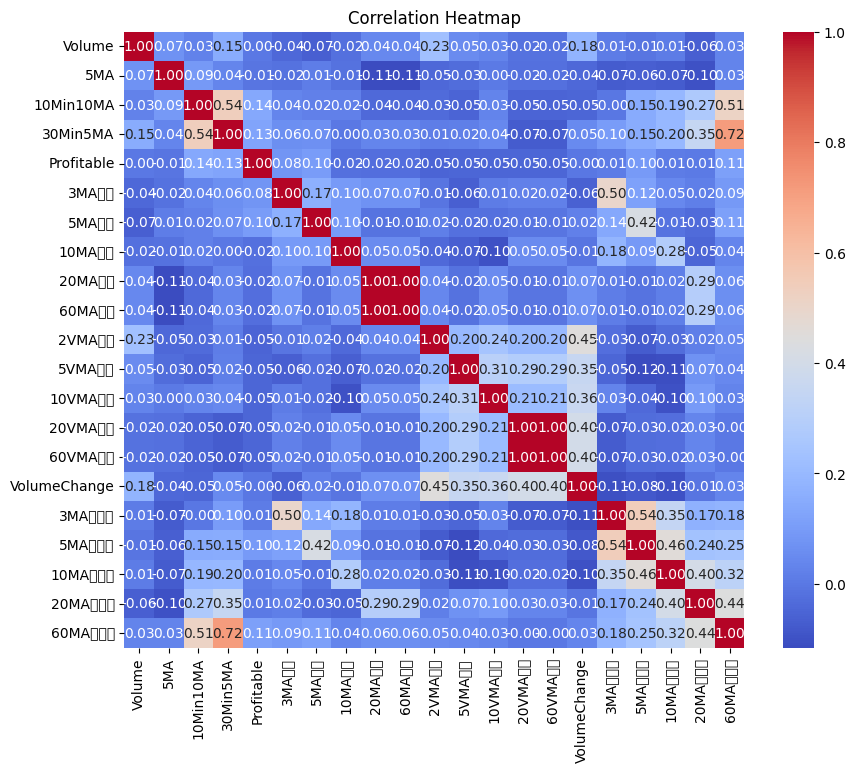


KeyboardInterrupt



In [291]:
# 데이터프레임에서 종속변수와 독립변수 추출
X = df3Min_Infection.drop(['Profitable', 'Timestamp'], axis=1)
y = df3Min_Infection['Profitable']

# 상관분석
correlation_matrix = df3Min_Infection.corr()
# correlation_matrix
# 상관계수 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 로지스틱 회귀분석
# 데이터 전처리: 독립변수 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할: 학습 데이터와 테스트 데이터
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
